In [1]:
import pyreadr

result = pyreadr.read_r('../raw_downloads/SDC_data_2021.rds')

# For .rds, there is usually a single object inside:
obj = list(result.values())[0]

print(type(obj))

<class 'pandas.core.frame.DataFrame'>


In [2]:
obj

,participants,SIC_primary,date_announced,date_terminated,business_description,participant_nation,alliance_deal_name,alliance_SIC_code,alliance_nation,status,type,ownership_structure,deal_number
0,Mitsubishi Heavy Industries,3731,1963-11-04,,"Mnfr,whl ships,power engine",Japan,MITSUBISHI HEAVY INDUSTRIES LTD/CATERPILLAR IN...,3531,Japan,Renegotiated,Joint Venture,67.0,1.725240e+09
1,Caterpillar Overseas S.A,3531,1963-11-04,,Mnfr constr equip,Switzerland,MITSUBISHI HEAVY INDUSTRIES LTD/CATERPILLAR IN...,3531,Japan,Renegotiated,Joint Venture,33.0,1.725240e+09
2,Banque Bruxelles Lambert SA,6000,1963-12-31,06/04/2007,Bank,Belgium,BANK BRUSSEL LAMBERT/KBC BANK -INTERNATIONAL F...,6153,Belgium,Terminated,Joint Venture,50.0,1.882730e+09
3,KBC Bank,6000,1963-12-31,06/04/2007,Bank,Belgium,BANK BRUSSEL LAMBERT/KBC BANK -INTERNATIONAL F...,6153,Belgium,Terminated,Joint Venture,50.0,1.882730e+09
4,BAM International NV,1522,1964-01-01,,Construction company,Netherlands,BAM INTERNATIONAL NV/CLOUGH OPERATIONS PTY LTD...,1522,Australia,Completed/Signed,Joint Venture,50.0,2.950130e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...
434120,Alpha Esports Tech Inc,7372,2021-09-14,,"Dvlp esports, online gaming platforms, and blo...",Canada,ALPHA ESPORTS TECH INC/NBA 2K LEAGUE LLC-STRAT...,7311,United States,Completed/Signed,Strategic Alliance,NaN,3.799979e+09
434121,Nba 2k League Llc,7911,2021-09-14,,All Other Amusement and Recreation Industries,United States,ALPHA ESPORTS TECH INC/NBA 2K LEAGUE LLC-STRAT...,7311,United States,Completed/Signed,Strategic Alliance,NaN,3.799979e+09
434122,EQ Group LLC,4953,2021-09-15,,Hazardous Waste Treatment and Disposal,United States,EQ GROUP LLC/NEC PAYMENTS BSC-STRATEGIC ALLIANCE,6289,Bahrain,Completed/Signed,Strategic Alliance,NaN,3.799934e+09
434123,Nec Payments Bsc,6282,2021-09-15,,Miscellaneous Financial Investment Activities,Bahrain,EQ GROUP LLC/NEC PAYMENTS BSC-STRATEGIC ALLIANCE,6289,Bahrain,Completed/Signed,Strategic Alliance,NaN,3.799934e+09


In [3]:
import pyreadr
import pandas as pd
from itertools import combinations
import unicodedata

# ---------- 1. Load the RDS and clean column names ----------
result = pyreadr.read_r('../raw_downloads/SDC_data_2021.rds')
sdc = list(result.values())[0]  # SDC data frame

# mimic janitor::clean_names()
sdc.columns = (
    sdc.columns
      .str.strip()
      .str.lower()
      .str.replace(r"[^0-9a-zA-Z]+", "_", regex=True)
)

# ---------- 2. Clean participants and filter strategic alliances ----------
# Clean participants like in R: trim, turn "", "NA", "<NA>" into real NA
sdc["participants"] = (
    sdc["participants"]
    .astype(str)
    .str.strip()
    .replace({"": pd.NA, "NA": pd.NA, "<NA>": pd.NA})
)

# Filter: Completed/Signed & Strategic Alliance
mask = (sdc["status"] == "Completed/Signed") & (sdc["type"] == "Strategic Alliance")
sdc_filt = sdc.loc[mask].copy()

# Keep only rows with a non-missing participant
sdc_filt = sdc_filt[sdc_filt["participants"].notna()].copy()


# ---------- 3. Clean firm names (ASCII, trimmed) ----------
def clean_firm_name(x):
    if pd.isna(x):
        return pd.NA
    x = str(x).strip()
    # approximate R's iconv(to = "ASCII//TRANSLIT")
    x = unicodedata.normalize("NFKD", x).encode("ascii", "ignore").decode("ascii")
    x = x.strip()
    return x if x else pd.NA

sdc_filt["firm"] = sdc_filt["participants"].apply(clean_firm_name)
sdc_filt = sdc_filt[sdc_filt["firm"].notna()].copy()

# We assume columns: 'deal_number' and 'sic_primary' exist (as in your R code)


# ---------- 4. Build firm–firm edges (co-alliance network) ----------
edges = []

for deal_id, group in sdc_filt.groupby("deal_number"):
    firms = sorted(group["firm"].unique())
    if len(firms) < 2:
        continue
    # all unordered firm pairs within each deal
    for a, b in combinations(firms, 2):
        if a != b:
            edges.append((a, b))

edges_df = pd.DataFrame(edges, columns=["from_firm", "to_firm"]).drop_duplicates()

# If there are no edges (degenerate case)
if edges_df.empty:
    raise ValueError("No edges found after filtering; check your data and filters.")


# ---------- 5. Compute degree (number of edges) per firm ----------
# Count how many times each firm appears in 'from_firm' and 'to_firm'
deg_from = edges_df.groupby("from_firm").size()
deg_to = edges_df.groupby("to_firm").size()

# Sum contributions from both ends
deg_series = deg_from.add(deg_to, fill_value=0).astype(int)

degree_df = (
    deg_series
    .rename("degree")
    .reset_index()
    .rename(columns={"index": "firm"})
)

# ---------- 6. Attach SIC codes to firms ----------
firm_info = (
    sdc_filt[["firm", "sic_primary"]]
    .dropna()
    .drop_duplicates()
)

degree_with_sic = (
    degree_df
    .merge(firm_info, on="firm", how="left")
    .dropna(subset=["sic_primary"])
)

# ---------- 7. Aggregate: mean & median degree per SIC code ----------
sic_stats = (
    degree_with_sic
    .groupby("sic_primary")["degree"]
    .agg(["mean", "median", "count"])
    .reset_index()
    .rename(columns={"count": "n_firms"})
)

# Sort by mean degree (descending)
sic_stats_sorted_by_mean = sic_stats.sort_values("mean", ascending=False)

# Sort by median degree (descending)
sic_stats_sorted_by_median = sic_stats.sort_values("median", ascending=False)

# ---------- 8. Show top SIC codes ----------
top_k = 10  # change if you want more/less

print("Top SIC codes by MEAN degree (edges per firm):")
print(sic_stats_sorted_by_mean.head(top_k))

print("\nTop SIC codes by MEDIAN degree (edges per firm):")
print(sic_stats_sorted_by_median.head(top_k))


Top SIC codes by MEAN degree (edges per firm):
    sic_primary       mean  median  n_firms
136        2074  23.000000    23.0        1
217        2449  11.500000    11.5        2
517        3769   9.545455     5.0       11
254        2732   8.857143     2.0        7
242        2657   8.200000     2.0        5
355        3316   7.800000     1.0       15
346        3291   7.416667     1.0       12
450        3571   7.295950     1.0      642
663        5131   6.692308     1.0       13
454        3578   6.060000     1.0       50

Top SIC codes by MEDIAN degree (edges per firm):
    sic_primary       mean  median  n_firms
136        2074  23.000000    23.0        1
217        2449  11.500000    11.5        2
19         0189   5.000000     5.0        1
517        3769   9.545455     5.0       11
2          0115   4.000000     4.0        2
474        3633   5.250000     4.0        4
813        7041   4.000000     4.0        1
742        5948   3.500000     3.5        2
265        2796   3.000

In [6]:
sic_stats_sorted_by_mean.query("n_firms > 50")

,sic_primary,mean,median,n_firms
450,3571,7.295950,1.0,642
485,3651,5.632867,1.0,286
585,4512,4.851016,1.0,443
639,5051,4.475410,1.0,61
453,3577,4.230543,1.0,681
...,...,...,...,...
652,5087,1.178571,1.0,56
305,3069,1.170732,1.0,82
91,1711,1.166667,1.0,54
919,8111,1.156069,1.0,173


In [40]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
import unicodedata
from itertools import combinations


def clean_firm_name(x: str):
    """Approximate R's iconv(to='ASCII//TRANSLIT') + trimws + NA handling."""
    if pd.isna(x):
        return None
    x = str(x).strip()
    # remove accents / weird chars
    x = unicodedata.normalize("NFKD", x).encode("ascii", "ignore").decode("ascii")
    x = x.strip()
    return x or None


def plot_alliance_network_for_code(
    df: pd.DataFrame,
    alliance_sic_code,
    figsize=(8, 6),
    min_degree=0,
):
    """
    Plot firm–firm strategic alliance network for a given alliance_sic_code.

    Nodes: participants (firms)
    Edge: two firms appear together in at least one deal_number
          with the given alliance_sic_code, and
          status == 'Completed/Signed' & type == 'Strategic Alliance'.

    Parameters
    ----------
    df : pd.DataFrame
        Must contain columns:
        ['participants', 'sic_primary', 'date_announced', 'date_terminated',
         'business_description', 'participant_nation', 'alliance_deal_name',
         'alliance_sic_code', 'alliance_nation', 'status', 'type',
         'ownership_structure', 'deal_number'].
    alliance_sic_code : int or str
        The value to match in 'alliance_sic_code'.
    figsize : tuple
        Size of the matplotlib figure.
    min_degree : int
        Optionally hide nodes with degree < min_degree (for clearer plots).

    Returns
    -------
    G : networkx.Graph or None
        The firm–firm network (None if no data).
    """

    df_local = df.copy()

    # --- 1. Clean participants ---
    df_local["participants"] = (
        df_local["participants"]
        .astype(str)
        .str.strip()
        .replace({"": pd.NA, "NA": pd.NA, "<NA>": pd.NA})
    )
    df_local["firm"] = df_local["participants"].apply(clean_firm_name)
    df_local = df_local[df_local["firm"].notna()].copy()

    # --- 2. Filter to completed, signed strategic alliances ---
    mask_core = (
        (df_local["status"] == "Completed/Signed")
        & (df_local["type"] == "Strategic Alliance")
    )
    df_local = df_local.loc[mask_core].copy()

    # --- 3. Filter by alliance_sic_code ---
    # Cast both sides to string so 7372 and 7372.0 both match.
    df_local["alliance_sic_code_str"] = df_local["alliance_sic_code"].astype(str)
    target_code_str = str(alliance_sic_code)

    df_local = df_local[df_local["alliance_sic_code_str"] == target_code_str].copy()

    if df_local.empty:
        print(f"No completed strategic alliances found for alliance_sic_code={alliance_sic_code}.")
        return None

    # --- 4. Build firm–firm edges from co-participation in the same deal_number ---
    edges = []
    for deal_id, group in df_local.groupby("deal_number"):
        firms = sorted(group["firm"].unique())
        if len(firms) < 2:
            continue
        for a, b in combinations(firms, 2):
            if a != b:
                edges.append((a, b))

    if not edges:
        print(f"No multi-participant deals for alliance_sic_code={alliance_sic_code}.")
        return None

    G = nx.Graph()
    G.add_edges_from(edges)

    # Optionally prune very low-degree nodes to declutter
    if min_degree > 1:
        to_remove = [n for n, d in G.degree() if d < min_degree]
        G.remove_nodes_from(to_remove)

    if G.number_of_nodes() == 0:
        print("Graph is empty after applying min_degree filter.")
        return None

    # --- 5. Plot ---
    plt.figure(figsize=figsize)
    pos = nx.spring_layout(G, seed=2001525)  # deterministic layout

    degrees = dict(G.degree())
    node_sizes = [3 + 3 * degrees[n] for n in G.nodes()]  # scale size by degree

    nx.draw_networkx_nodes(
        G,
        pos,
        node_size=node_sizes,
        node_color="coral"
    )
    nx.draw_networkx_edges(
        G,
        pos,
        width=1.2,
        alpha=0.3
    )

    plt.axis("off")
    title = (
        f"Strategic Alliances Network\n"
        f"alliance_sic_code = {alliance_sic_code} | "
        f"Nodes: {G.number_of_nodes()} | Edges: {G.number_of_edges()}"
    )
    plt.title(title)
    plt.tight_layout()
    plt.show()

    return G


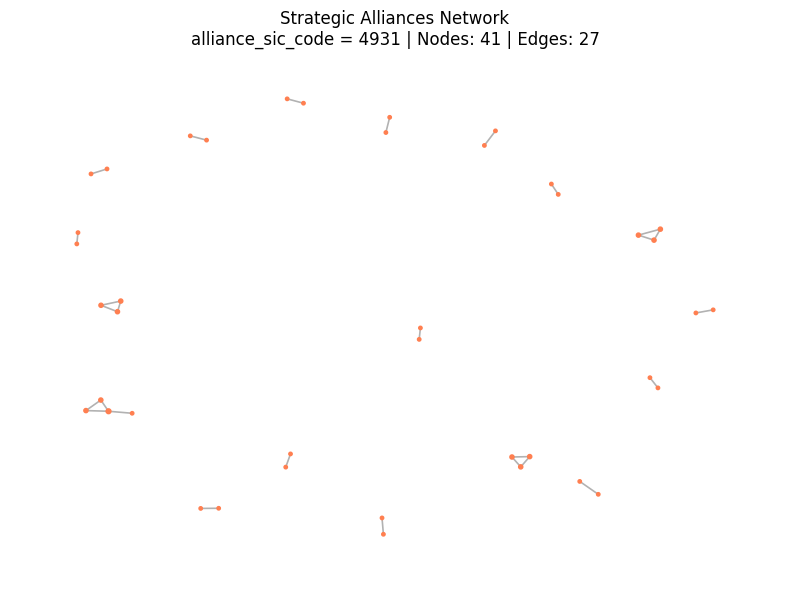

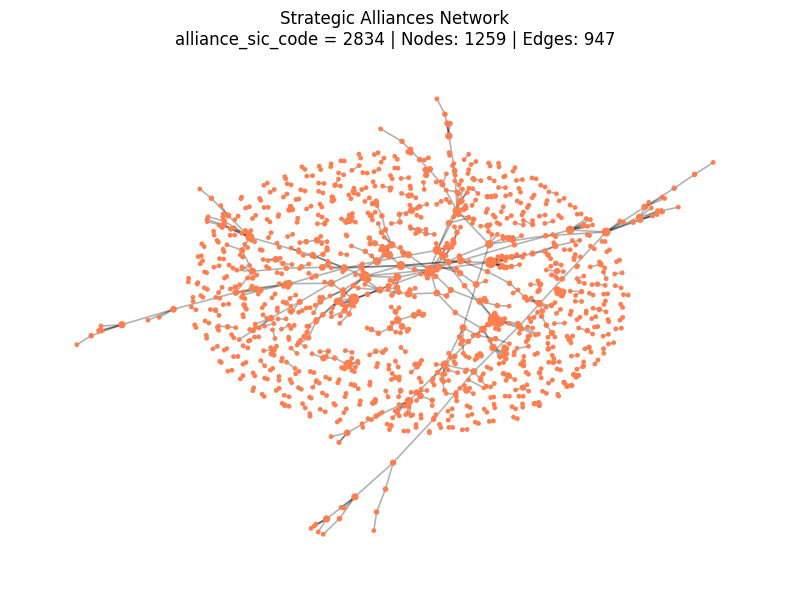

In [41]:
# Suppose 'sdc' is your full DataFrame loaded from the RDS

# Example: plot network for alliance_sic_code 7372
G_7372 = plot_alliance_network_for_code(sdc, alliance_sic_code=4931)

# Example: plot network for alliance_sic_code 2834
G_2834 = plot_alliance_network_for_code(sdc, alliance_sic_code=2834, min_degree=2)


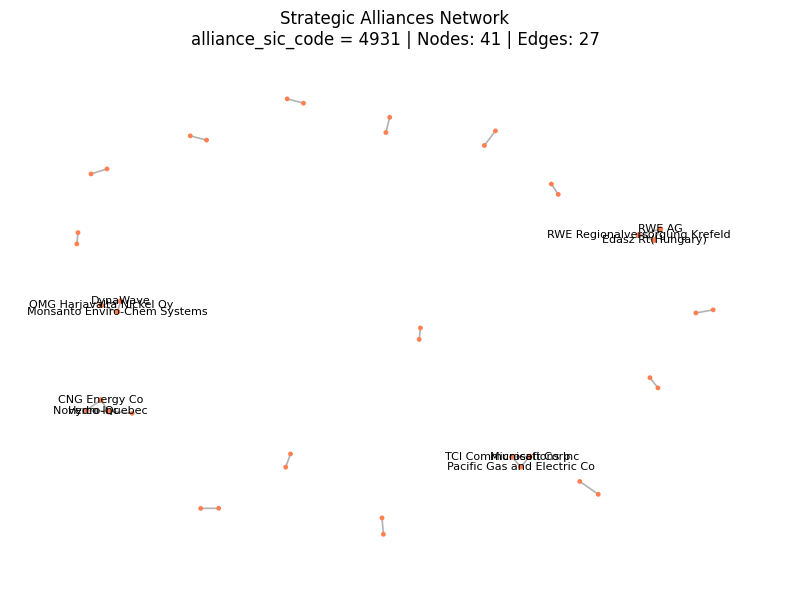

In [33]:
plot_alliance_network_for_code(sdc, alliance_sic_code=4931)

In [36]:
from pycountry_convert import (
    country_name_to_country_alpha2,
    country_alpha2_to_continent_code,
)

def country_to_continent(country_name: str) -> str:
    try:
        alpha2 = country_name_to_country_alpha2(country_name)
        cont_code = country_alpha2_to_continent_code(alpha2)
    except Exception:
        return "Unknown"

    # Map continent codes to names
    code_to_name = {
        "AF": "Africa",
        "NA": "North America",
        "OC": "Oceania",
        "AN": "Antarctica",
        "AS": "Asia",
        "EU": "Europe",
        "SA": "South America",
    }
    return code_to_name.get(cont_code, "Unknown")

print(country_to_continent("Netherlands"))  # 'Europe'
print(country_to_continent("United States"))  # 'North America'


Europe
North America


In [37]:
sdc["continent"] = sdc["participant_nation"].apply(country_to_continent)

In [39]:
sdc.query("continent == 'Unknown'")["participant_nation"].value_counts()

participant_nation
Unknown           5957
Russian Fed       4154
Utd Arab Em       2572
Ireland-Rep       1440
Soviet Union       512
Czechoslovakia     299
Myanmar(Burma)     239
British Virgin     158
Slovak Rep         115
Papua N Guinea      71
Yugoslavia          65
Trinidad&Tob        45
Rep of Congo        40
Bosnia              36
Neth Antilles       33
Dominican Rep       31
East Germany        27
Supranational       22
Zaire               15
Dem Rep Congo       14
Antigua              8
American Somoa       6
Serbia & Mont.       6
Reunion              6
Surinam              6
C. African Rep       6
                     6
Marshall Is          5
Equator Guinea       5
Western Somoa        5
Fr Polynesia         4
Solomon Is           3
St Lucia             3
Timor-Leste          3
St Kitts&Nevis       2
US Virgin Is         2
Falkland Is          1
N. Mariana           1
Sao Tome             1
Grenadines           1
St. Pierre           1
St. Helena           1
Name: count, dt

In [43]:
import pyreadr
import pandas as pd
from itertools import combinations
import unicodedata
import country_converter as coco  # for country -> continent mapping

# ---------- 1. Load the RDS and clean column names ----------
result = pyreadr.read_r('../raw_downloads/SDC_data_2021.rds')
sdc = list(result.values())[0]  # SDC data frame

# mimic janitor::clean_names()
sdc.columns = (
    sdc.columns
      .str.strip()
      .str.lower()
      .str.replace(r"[^0-9a-zA-Z]+", "_", regex=True)
)

# ---------- 2. Clean participants and filter strategic alliances ----------
# Clean participants like in R: trim, turn "", "NA", "<NA>" into real NA
sdc["participants"] = (
    sdc["participants"]
    .astype(str)
    .str.strip()
    .replace({"": pd.NA, "NA": pd.NA, "<NA>": pd.NA})
)

# Filter: Completed/Signed & Strategic Alliance
mask = (sdc["status"] == "Completed/Signed") & (sdc["type"] == "Strategic Alliance")
sdc_filt = sdc.loc[mask].copy()

# Keep only rows with a non-missing participant
sdc_filt = sdc_filt[sdc_filt["participants"].notna()].copy()


# ---------- 3. Clean firm names (ASCII, trimmed) ----------
def clean_firm_name(x):
    if pd.isna(x):
        return pd.NA
    x = str(x).strip()
    # approximate R's iconv(to = "ASCII//TRANSLIT")
    x = unicodedata.normalize("NFKD", x).encode("ascii", "ignore").decode("ascii")
    x = x.strip()
    return x if x else pd.NA

sdc_filt["firm"] = sdc_filt["participants"].apply(clean_firm_name)
sdc_filt = sdc_filt[sdc_filt["firm"].notna()].copy()

# ---------- 3b. Map participant_nation -> continent ----------
cc = coco.CountryConverter()

# convert returns e.g. 'Europe', 'Asia', or 'not found'
sdc_filt["continent"] = cc.convert(
    names=sdc_filt["participant_nation"],
    to="continent"
)

# Set unknown / not found to NA
sdc_filt.loc[sdc_filt["continent"] == "not found", "continent"] = pd.NA


# ---------- 4. Build firm–firm edges (co-alliance network) ----------
edges = []

for deal_id, group in sdc_filt.groupby("deal_number"):
    firms = sorted(group["firm"].unique())
    if len(firms) < 2:
        continue
    # all unordered firm pairs within each deal
    for a, b in combinations(firms, 2):
        if a != b:
            edges.append((a, b))

edges_df = pd.DataFrame(edges, columns=["from_firm", "to_firm"]).drop_duplicates()

# If there are no edges (degenerate case)
if edges_df.empty:
    raise ValueError("No edges found after filtering; check your data and filters.")


# ---------- 5. Compute degree (number of edges) per firm ----------
# Count how many times each firm appears in 'from_firm' and 'to_firm'
deg_from = edges_df.groupby("from_firm").size()
deg_to = edges_df.groupby("to_firm").size()

# Sum contributions from both ends
deg_series = deg_from.add(deg_to, fill_value=0).astype(int)

degree_df = (
    deg_series
    .rename("degree")
    .reset_index()
    .rename(columns={"index": "firm"})
)

# ---------- 6. Attach SIC codes + continent to firms ----------
firm_info = (
    sdc_filt[["firm", "sic_primary", "continent"]]
    .dropna(subset=["sic_primary"])   # we need sic_primary for the grouping
    .drop_duplicates()
)

degree_with_meta = (
    degree_df
    .merge(firm_info, on="firm", how="left")
)

# Optional: if you want to drop firms with missing SIC
degree_with_sic = degree_with_meta.dropna(subset=["sic_primary"]).copy()


# ---------- 7. Overall mean & median degree (all alliances) ----------
overall_stats = degree_df["degree"].agg(["mean", "median", "count"]).rename({
    "mean": "overall_mean_degree",
    "median": "overall_median_degree",
    "count": "n_firms"
})

print("=== Overall network stats (all alliances) ===")
print(overall_stats)
print()


# ---------- 8. Aggregate: mean & median degree per SIC code ----------
sic_stats = (
    degree_with_sic
    .groupby("sic_primary")["degree"]
    .agg(["mean", "median", "count"])
    .reset_index()
    .rename(columns={"count": "n_firms"})
)

# Sort by mean degree (descending)
sic_stats_sorted_by_mean = sic_stats.sort_values("mean", ascending=False)

# Sort by median degree (descending)
sic_stats_sorted_by_median = sic_stats.sort_values("median", ascending=False)

top_k = 10

print("=== Top SIC codes by MEAN degree (edges per firm) ===")
print(sic_stats_sorted_by_mean.head(top_k))
print()

print("=== Top SIC codes by MEDIAN degree (edges per firm) ===")
print(sic_stats_sorted_by_median.head(top_k))
print()


# ---------- 9. Breakdown: mean & median degree per SIC × continent ----------
# We keep continent even if it's NA, but you can drop NA if you want.
sic_continent_stats = (
    degree_with_sic
    .groupby(["sic_primary", "continent"])["degree"]
    .agg(["mean", "median", "count"])
    .reset_index()
    .rename(columns={"count": "n_firms"})
    .sort_values(["sic_primary", "continent"])
)

print("=== SIC × Continent degree stats (mean, median, n_firms) ===")
print(sic_continent_stats.head(30))  # show first few; adjust as needed

# If you want the full table for further analysis:
# sic_continent_stats.to_csv("sic_continent_stats.csv", index=False)


Soviet Union not found in regex
Unknown not found in regex
Neth Antilles not found in regex
Neth Antilles not found in regex
Unknown not found in regex
Soviet Union not found in regex
Unknown not found in regex
Yugoslavia not found in regex
Soviet Union not found in regex
Soviet Union not found in regex
Unknown not found in regex
Unknown not found in regex
Soviet Union not found in regex
Soviet Union not found in regex
Soviet Union not found in regex
Neth Antilles not found in regex
Neth Antilles not found in regex
East Germany not found in regex
Soviet Union not found in regex
Soviet Union not found in regex
Soviet Union not found in regex
Soviet Union not found in regex
Unknown not found in regex
Soviet Union not found in regex
Neth Antilles not found in regex
Soviet Union not found in regex
Soviet Union not found in regex
Soviet Union not found in regex
Soviet Union not found in regex
Soviet Union not found in regex
Unknown not found in regex
Soviet Union not found in regex
Unknown 

=== Overall network stats (all alliances) ===
overall_mean_degree           2.101969
overall_median_degree         1.000000
n_firms                  102051.000000
Name: degree, dtype: float64

=== Top SIC codes by MEAN degree (edges per firm) ===
    sic_primary       mean  median  n_firms
136        2074  23.000000    23.0        1
217        2449  11.500000    11.5        2
517        3769   9.545455     5.0       11
254        2732   8.857143     2.0        7
242        2657   8.200000     2.0        5
355        3316   7.800000     1.0       15
346        3291   7.416667     1.0       12
450        3571   7.295950     1.0      642
663        5131   6.692308     1.0       13
454        3578   6.060000     1.0       50

=== Top SIC codes by MEDIAN degree (edges per firm) ===
    sic_primary       mean  median  n_firms
136        2074  23.000000    23.0        1
217        2449  11.500000    11.5        2
19         0189   5.000000     5.0        1
517        3769   9.545455     5.0  

In [47]:
sic_continent_stats.query("n_firms > 50")

,sic_primary,continent,mean,median,n_firms
149,1021,America,2.022727,1.0,88
158,1041,America,1.469466,1.0,524
160,1041,Europe,1.884615,1.0,52
161,1041,Oceania,1.708772,1.0,285
177,1094,America,1.527778,1.0,72
...,...,...,...,...,...
3207,8748,America,1.373932,1.0,936
3208,8748,Asia,1.238710,1.0,155
3209,8748,Europe,1.376471,1.0,255
3212,8999,America,1.253521,1.0,71


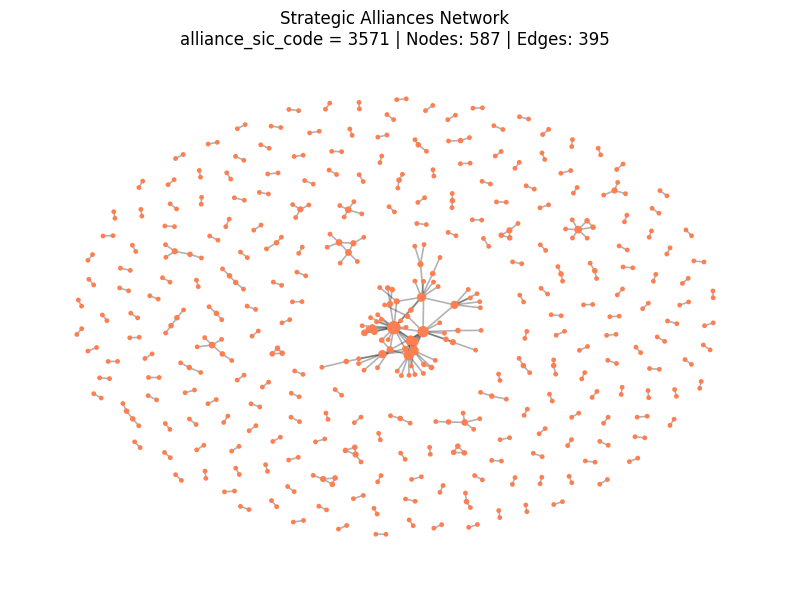

In [49]:
plot_alliance_network_for_code(sdc_filt.query("continent == 'America'"), alliance_sic_code=3571)

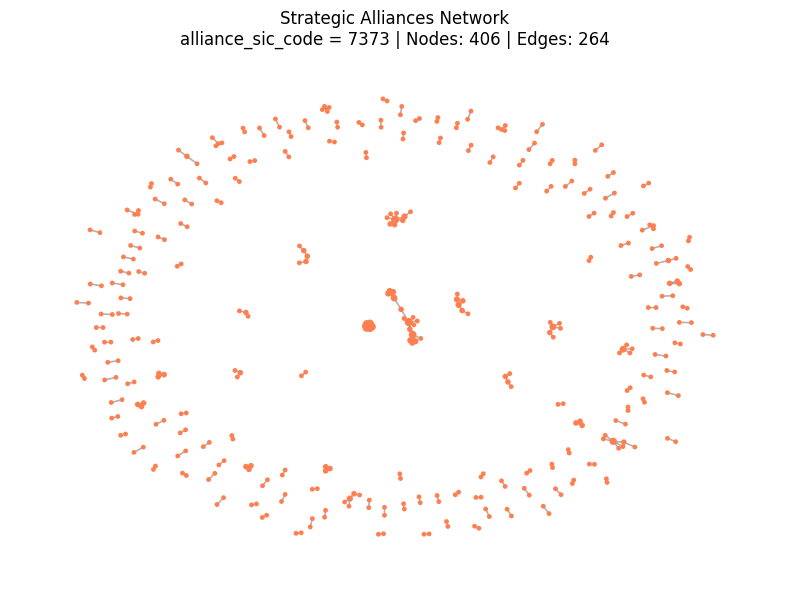

In [53]:
plot_alliance_network_for_code(sdc_filt.query("continent == 'Asia'"), alliance_sic_code=7373)

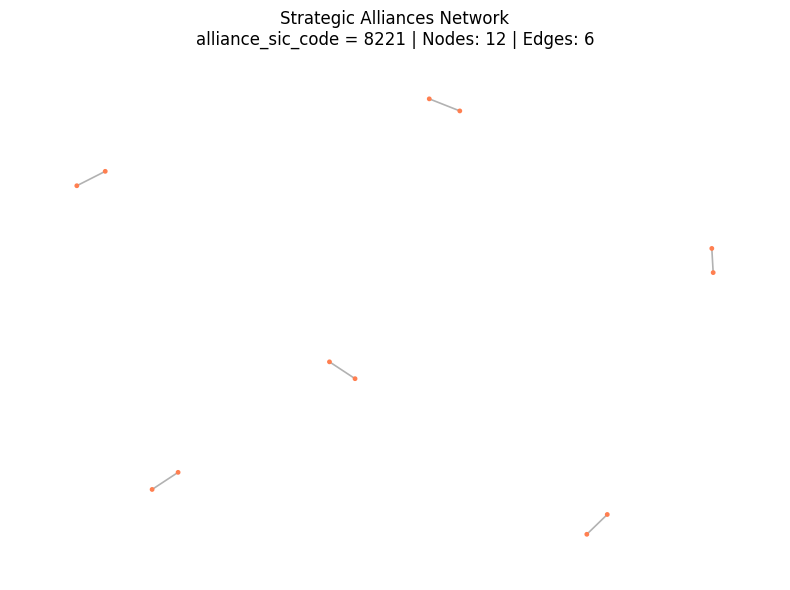

In [54]:
plot_alliance_network_for_code(sdc_filt.query("continent == 'America'"), alliance_sic_code=8221)